# 01. Preprocessing Street View Housing Numbers (SVHN) Dataset

### Purpose:
Convert the annotations provided with the SVHN dataset to the Darknet TXT format.

### Before Running Notebook:
1. Download train.tar.gz and test.tar.gz from [here](http://ufldl.stanford.edu/housenumbers/).
1. Extract the files into the Data folder at the top level of this repository.
1. The relative path from this notebook to the extracted train and test files must be assigned to the path variable in the final two cells.
1. The `digitStruct.mat` file must be included in the same directory as the images that it describes.

### Details:
The annotations for the SVHN dataset are provided as an h5py formatted file named `digitStruct.mat`.  There is one file for train and one for test.  In this project, I will be using Darknet to train custom Yolo models with this dataset, and Darknet requires annotations to be separated into one text file per image.  

More information about Darknet annotation format can be found [here](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects).


In [39]:
import os
import cv2 as cv
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

## Defining Functions
---

In [48]:
def create_annot_file(f_name, path):
    """
    Create a single Darknet TXT annotation file for an image.
    Writes to file <image name>.txt in same directory as image.

    Args
        f: digitStruct.mat h5py file
        path: path: path to digitStruct.mat
        idx: index of the image
        
    Returns:
        None
    """
    
    #open file
    f = sio.loadmat(path + f_name)
    
    # get bounding boxes
    boxes = f['tagp']
    
    # get dimensions of image
    try:
        (h_img, w_img) = cv.imread(path + f_name[:-4]).shape[:2]
    except:
        print(f"ERROR: Could not open {f_name[:-4]} to get dimensions.")
        print(f"Make sure image is in same directory as {f_name}")
        print(f"Tried:  {path + f_name[:-4]}")
        
    # initialize list for annotations
    annots = []
    
    for box in boxes:
        # get original bounding values
        (x, y) = (box[2], box[0])
        (w, h) = (box[3] - box[2], box[1] - box[0] )

        # transform x and y
        centerX = x + (w / 2)
        centerY = y + (h / 2)

        # normalize bounding values
        centerX /= w_img
        centerY /= h_img
        w /= w_img
        h /= h_img

        # append annotation in Darknet format to annotation list
        annots.append(f'{0} {centerX} {centerY} {w} {h}\n' )
    
    # write annotations to file 
    annot_file = open(path + f_name.split('.')[0] + '.txt', 'w')
    annot_file.writelines(annots)
    annot_file.close()

In [49]:
def create_annot_files(path):
    """
    Create Darknet TXT annotation file for all images in directory.
    Writes to files <image name>.txt in same directory as images.

    Args
        path: path to digitStruct.mat
        
    Returns:
        None
    """
    if path[-1] != '/':
        path += '/'
    
    try:
        f_list = [f for f in os.listdir(path) if f.endswith('.mat')]
    except:
        print("ERROR: Could not locate directory.  Check path.")
        
    if len(f_list) == 0:
        print("ERROR: Could not locate .mat files.  Check path.")
    else:  
        for f_name in f_list:
            create_annot_file(f_name, path)

## Create Annotation Files
___

In [29]:
# Create annotation files for set 1
path = '../DATA/RBNR/set1_org'
create_annot_files(path)

In [50]:
# Create annotation files for set 2
path = '../DATA/RBNR/set2_org'
create_annot_files(path)

# Test Annotation File
---

In [36]:
def darknet_to_standard(path, f_name, img):

    # get original image dimension
    (h_img, w_img) = img.shape[:2]
    
    #read in bounding box from Darknet file
    f = open(path + f_name)
    objects = f.readlines()
    
    boxes = []
    for obj in objects:
        # get bounding box values
        box = [float(i) for i in obj.strip().split()[1:]]
        # convert from normalized to original size
        sized_box = box * np.array([w_img, h_img, w_img, h_img])
        # convert x and y from center to corner
        (centerX, centerY, width, height) = sized_box.astype("int")
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        # reconfigure and save to list
        orig_box = [x, y, int(width), int(height)]
        boxes.append(orig_box)
    
    return boxes

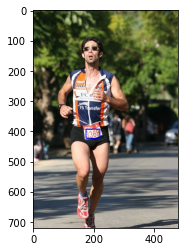

In [47]:
# set path and annotation file name
path = '../Data/RBNR/set1_org/'
f_name = 'set1_32.txt'

# open the image
img = cv.imread(path + f_name[:-4] + '.JPG')

# get all bounding boxes for the image
boxes = darknet_to_standard(path, f_name, img)

# mark boxes on image
for (x, y, w, h) in boxes:
    img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# display image
RGB_im = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(RGB_im)